<a href="https://colab.research.google.com/github/xujunlong666-crypto/Capstone/blob/main/Notebook_Satellite_based_Air_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**: Abhishek Anand\
Created: November 11, 2025


# Notebook: Using Satellite Data to Estimate Air Quality (PM2.5)

Welcome to the hands-on workshop!
In this session, you will learn how to:

- Access and visualize satellite data (MODIS AOD 550nm)
- Understand PM2.5 (particulate matter pollution)
- Combine satellite and ground sensor data
- Train regression models to estimate PM2.5 from AOD
- Produce spatial maps of PM2.5 over a region


In [2]:
# #Install required packages (if missing)
!pip install netCDF4 pyhdf pyproj geopandas shapely rasterio h5py
!pip install scikit-learn xarray matplotlib seaborn cartopy
!pip install earthengine-api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.3/780.3 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 97.1 MB/s eta 0:00:00


In [3]:
# !pip install numpy pandas matplotlib seaborn scikit-learn netCDF4
# numpy, pandas, matplotlib, cartopy, seaborn, xarray, rasterio, geopandas, netCDF4, earthengine-api

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import netCDF4 as nc

## 1. Setup and Imports

## 2. Access and Explore MODIS AOD Data

### 2.1. Download location-specific dataset from Google Earth
There is a lot of processed satellite data available from several agencies and universities (e.g. NASA, NOAA and ESA) on the Google Earth Engine platform. A few useful links are:

#### An Intro to the Earth Engine Python API
https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api

#### A list of All Datasets on Google Earth
https://developers.google.com/earth-engine/datasets/catalog

#### MCD19A2.061: Terra & Aqua MAIAC Land Aerosol Optical Depth Daily 1km
https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD19A2_GRANULES

### Steps to access Google Earth Engine
1. Go to [Google Cloud Console](https://console.cloud.google.com/)
(make sure you’re signed in with your new Google account).
2. Click “Create Project”\
	•	Give it a name like "My Project".\
	•	Copy the Project ID (this is what you’ll use in code and would look something like "western-beanbag-472120-d2").
3. Enable Earth Engine API for that project\
	•	Go to APIs & Services → Library.\
	•	Search for “Earth Engine API”.\
	•	Click Enable.
4. Register the Cloud project with Earth Engine.\
	•	Go to link: https://code.earthengine.google.com/register?project={PROJECT ID} and follow instructions.\
	•	Select the non-commercial usage option.\
	•	Choose academic institution.\
	•	Project: "Air quality study using satellite data".


In [4]:
!pip install tqdm

In [5]:
# Import earthengine-api as ee
import ee
ee.Authenticate() # Authenticate Earth Engine
ee.Initialize(project = 'resolute-tracer-478020-i4') # Initialize Earth Engine

from tqdm import tqdm

In [6]:
# Mount the drive contents
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Set working directory
import os
os.chdir("/content/drive/MyDrive/Air/Notebook")

In [8]:
import pandas as pd

In [9]:
# Define the list of locations/cities for aquiring AOD data
city_ls = ["Los Angeles","NYC", "Houston"]

# Define an output path
output_dir = "files/EE_AOD/"

# === Coordinates for the cities ===
# LA: 34.06659, -118.22688
# NYC: 40.83606, -73.92009
# Houston: 29.81453, -95.38769

lat_d = {
    "Los Angeles":34.06659,
    "NYC":40.83606,
    "Houston":29.81453
}

lon_d = {
    "Los Angeles":-118.22688,
    "NYC":-73.92009,
    "Houston":-95.38769
}

In [10]:
# It is the product ID for MODIS AOD
product_d = {
    "AOD":"MODIS/061/MCD19A2_GRANULES"
}

var_d = {
    "AOD":["Optical_Depth_055"] # We are specifically looking at AOD at 550 nm at 1 km spatial resolution
}

In [11]:
# get a time series:
# https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    #df = df[['time','datetime','longitude','latitude',  *list_of_bands]]
    df = df[['time','datetime',  *list_of_bands]]

    return df


def get_df(s, loc, point_buffer, product_d, var_d):
    collection = ee.ImageCollection(product_d[s]) \
        .filterBounds(loc) \
        .select(var_d[s]) \
        .filterDate('2024-01-01', '2025-08-31')

    lst = collection.getRegion(loc,point_buffer).getInfo()

    df = ee_array_to_df(lst,var_d[s])

    if s == "AOD":
        df[var_d[s]] = df[var_d[s]]*0.001

    df = df.set_index("datetime")[var_d[s]].resample("D").mean() # Resampled to daily AOD
    df = df.reset_index()
    df["time"] = df["datetime"].dt.date
    return df[["time"]+var_d[s]]

def merge_df(s_ls, loc, point_buffer, product_d, var_d):
    for s in s_ls:
        if s == s_ls[0]:
            df = get_df(s, loc=loc, point_buffer=point_buffer, product_d=product_d, var_d=var_d)
        else:
            df = pd.merge(df, get_df(s, loc=loc, point_buffer=point_buffer, product_d=product_d, var_d=var_d),
                          on="time", how="outer")
    return df

In [12]:
s_ls = ["AOD"]
for city in tqdm(city_ls):
    loc = ee.Geometry.Point(lon_d[city], lat_d[city])
    point_buffer = 200.0 # radius of a circular buffer around the point location, in meters
    df = merge_df(s_ls, loc, point_buffer, product_d, var_d)
    df["time"] = pd.to_datetime(df["time"])
    df = df[df["time"]<"2025-08-31"]
    df = df.sort_values(["time"]).reset_index(drop=True)
    df.columns = ['date', 'aod_550'] # rename columns
    df.to_csv(output_dir+city+".csv",index=False)

100%|██████████| 3/3 [01:57<00:00, 39.03s/it]


### 2.2. Visualize raw AOD data

##### 2.2.1 Combine AOD files for all cities

In [13]:
import os


input_dir = "files/EE_AOD/"

city_ls = ["Los Angeles", "NYC", "Houston"]

all_cities = []

for city in city_ls:
    #print(city)
    file = os.path.join(input_dir, f"{city}.csv")
    df = pd.read_csv(file)
    df["city"] = city   # optional: keep track of which city each row is from
    all_cities.append(df)

# Combine into one DataFrame
all_cities_df = pd.concat(all_cities, axis=0, ignore_index=True)

all_cities_df.to_csv("files/EE_AOD/All_Cities_AOD.csv", index = False)

#### 2.2.2 Analyze AOD data

**Data availability**

In [14]:
import pandas as pd

df = pd.read_csv("files/EE_AOD/All_Cities_AOD.csv")

# Ensure date column is datetime
df["date"] = pd.to_datetime(df["date"])

# Group by city and count non-NaN vs total rows
availability = df.groupby("city")["aod_550"].agg(
    valid_count="count",          # non-NaN values
    total_count="size"            # total rows
).reset_index()

# Compute percentage
availability["availability"] = ((availability["valid_count"] / availability["total_count"]) * 100).round(1)

print(availability)

          city  valid_count  total_count  availability
0      Houston          230          603          38.1
1  Los Angeles          435          608          71.5
2          NYC          297          607          48.9


This suggests that for Los Angeles, the MODIS dataset provides relatively consistent daily observations, whereas for NYC and Houston, nearly half of the days are missing valid AOD measurements. These differences could be due to cloud cover, satellite overpass timing, or regional atmospheric conditions affecting the retrieval of aerosol optical depth.

**Boxplots / Violin Plots**

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns



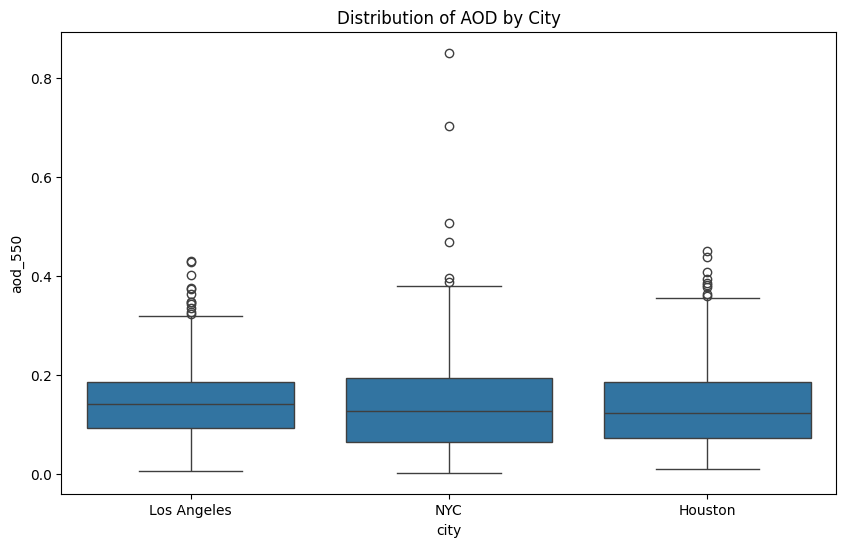

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="city", y="aod_550")
plt.title("Distribution of AOD by City")
plt.show()

**Key Takeaways:**
- City differences: Aerosol Optical Depth (AOD) shows clear variation across different cities.
- Outliers: The unusually high AOD values in NYC are probably linked to Canadian wildfire smoke events.

**Time Series Plots**

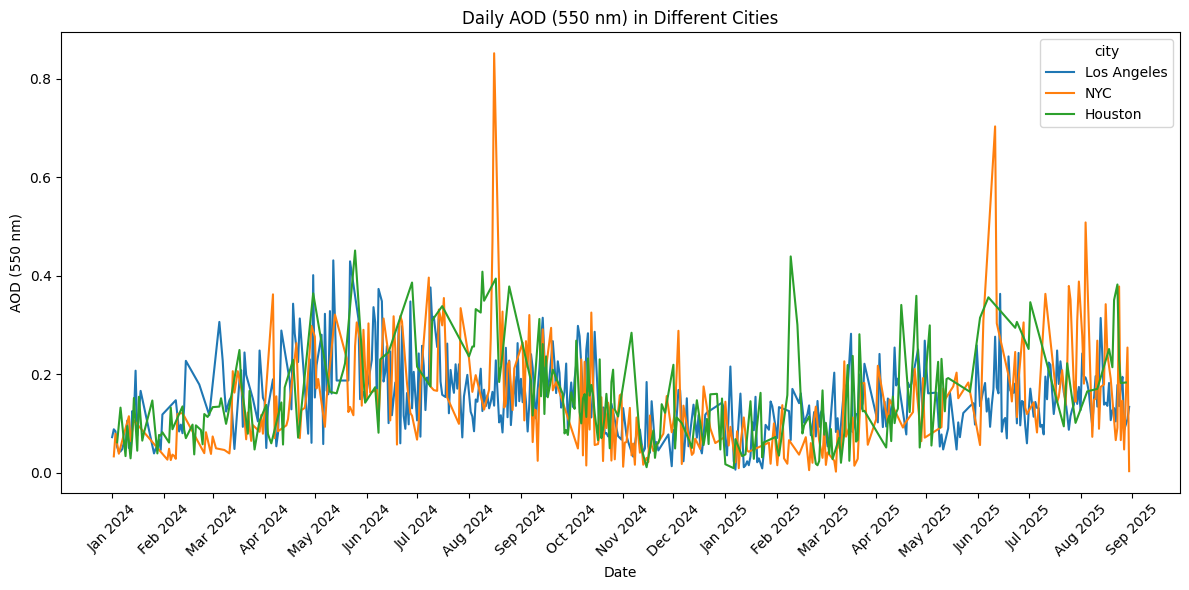

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

# Ensure 'date' column is datetime
df["date"] = pd.to_datetime(df["date"])

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="date", y="aod_550", hue="city")

# Title and labels
plt.title("Daily AOD (550 nm) in Different Cities")
plt.ylabel("AOD (550 nm)")
plt.xlabel("Date")

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

# Can be use to highlight anomalies
# plt.axvspan(pd.Timestamp("2025-01-01"), pd.Timestamp("2025-01-15"),
#             color='lightgrey', alpha=0.7)

plt.tight_layout()
plt.show()

**Key Takeaways:**
- City differences: Aerosol Optical Depth (AOD) shows clear variation across different cities.
- Seasonal differences: AOD shows a seasonal trend for each city. It is higher during the summer indicating more aerosol-based light extinction.

The seasonal trend can be prominently observed in the monthly plot below.

**Monthly averages**

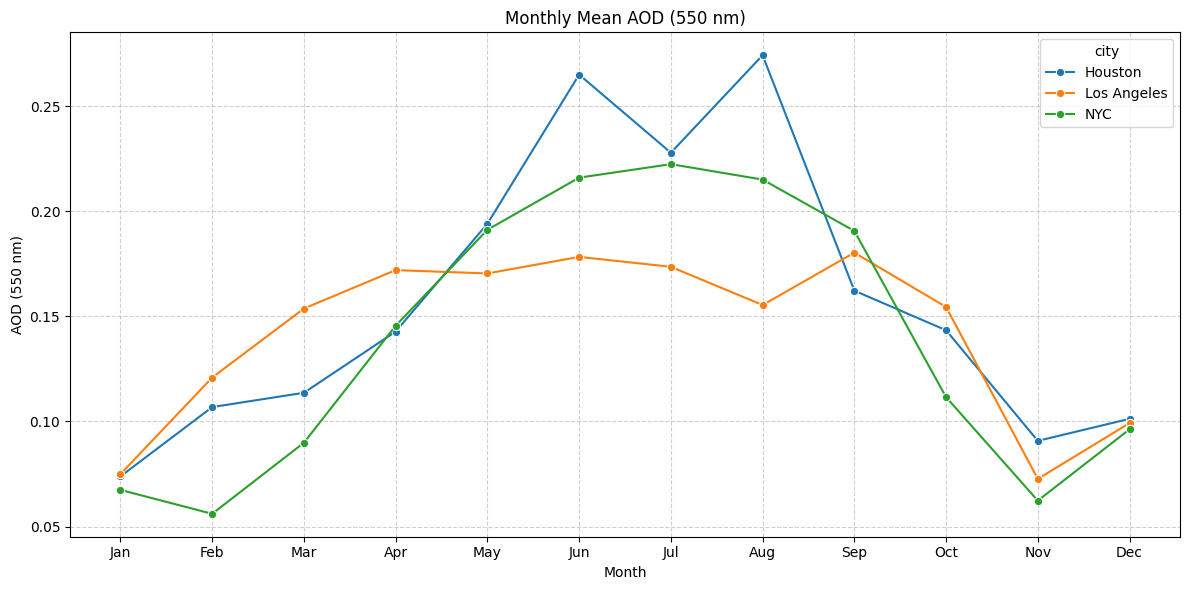

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure date column is datetime
df["date"] = pd.to_datetime(df["date"])

# Extract month number & month name
df["month"] = df["date"].dt.month
df["month_name"] = df["date"].dt.strftime("%b")

# Group by city and month
monthly = df.groupby(["month", "month_name", "city"])["aod_550"].mean().reset_index()

# Correct month order (1–12)
month_order = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Plot
plt.figure(figsize=(12,6))

# # Shade anomalies
# plt.axvspan(-0.5, 0.5, color='lightgrey', alpha=0.3)  # covers first tick "Jan"

sns.lineplot(
    data=monthly,
    x="month_name",
    y="aod_550",
    hue="city",
    marker="o"
)

plt.title("Monthly Mean AOD (550 nm)")
plt.ylabel("AOD (550 nm)")
plt.xlabel("Month")
plt.xticks(ticks=range(12), labels=month_order)  # enforce correct order
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### 2.3. Download Spatial AOD data

**Steps**:
1. Create an account on NASA Earthdata, which is a portal to download varied satelite-based products
2. Go to https://search.earthdata.nasa.gov and use the NASA Earthdata credentials to login to the website.
3. Use product ID "MCD19A2" (v61) to search for MODIS Aerosol Optical Depth. (MODIS/Terra+Aqua Land Aerosol Optical Depth Daily L2G Global 1km SIN Grid V061)
4. Select granules and download it to your system

**Sample file**: "MCD19A2.A2025254.h12v04.061.2025255204816.hdf"

MODIS/Terra+Aqua Land Aerosol Optical Depth Daily L2G Global 1km SIN Grid V061\
https://www.earthdata.nasa.gov/data/catalog/lpcloud-mcd19a2-061

The documentation for this satellite product can be found below:\
https://lpdaac.usgs.gov/documents/1500/MCD19_User_Guide_V61.pdf

MCD19A2.A2025254.h12v04.061.2025255204816.hdf\
	•	MCD19A2 → MODIS Terra+Aqua MAIAC daily aerosol product (AOD).\
	•	A2025254 → Acquisition date in YYYYDDD format (2025-254 → 11 September 2025). 254 is day-of-year (DOY)\
	•	h12v04 → MODIS tile horizontal/vertical index (tile h12v04).\
	•	061 → MODIS collection version (Collection 6.1).\
	•	The last numbers → internal file version/timestamp for processed or uploaded date.\
	•	.hdf → HDF4 file format (Hierarchical Data Format).

#### Load and visualize spatial AOD data
The files are in "hdf4" format.

In [19]:
from pyhdf.SD import SD, SDC

# Path to your HDF4 file
file_path = "files/NASA_AOD/MCD19A2.A2025254.h12v04.061.2025255204816.hdf"

# Open the file
hdf = SD(file_path, SDC.READ)

# List all datasets (SDS = Scientific Data Sets)
datasets_dict = hdf.datasets()
print("Datasets in file:")
for idx, (name, info) in enumerate(datasets_dict.items()):
    print(f"{name} -> {info}")

Datasets in file:
Optical_Depth_047 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (6, 1200, 1200), 22, 0)
Optical_Depth_055 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (6, 1200, 1200), 22, 1)
AOD_Uncertainty -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (6, 1200, 1200), 22, 2)
Column_WV -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (6, 1200, 1200), 22, 3)
AngstromExp_470-780 -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (6, 1200, 1200), 22, 4)
AOD_QA -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (6, 1200, 1200), 23, 5)
FineModeFraction -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (6, 1200, 1200), 5, 6)
Injection_Height -> (('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km'), (6, 1200, 1200), 5, 7)
cosSZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (6, 240, 240), 22, 8)
cosVZA -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km'), (6, 240, 240), 22, 9)
RelAZ -> (('Orbits:grid5km', 'YDim:grid5km', 'XDim:

In [20]:
aod = hdf.select('Optical_Depth_055')  # choose your dataset
data = aod.get()  # numpy array
attrs = aod.attributes()
print(attrs)  # metadata like scale factor, fill value

{'long_name': 'AOD at 0.55 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 6000]}


In [21]:
import numpy as np

fill_value = attrs['_FillValue']  # use string key
scale_factor = attrs['scale_factor']

data = np.where(data != fill_value, data * scale_factor, np.nan)

/tmp/ipython-input-1674885515.py:6: RuntimeWarning: Mean of empty slice
  aod_mean = np.nanmean(data, axis=0)  # result shape: (1200, 1200)


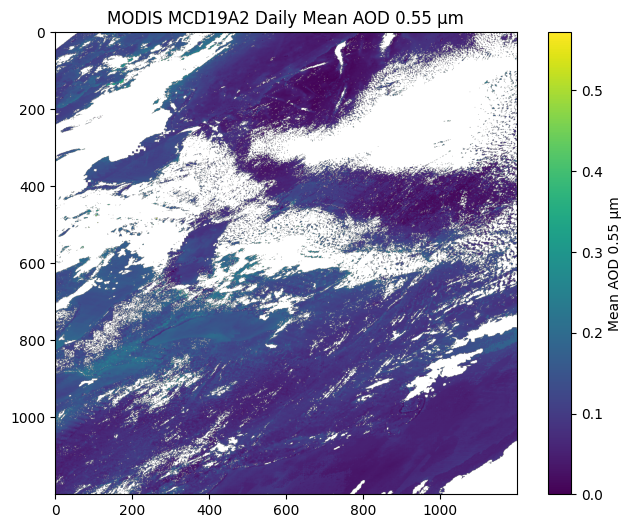

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 'data' is your original array with shape (4, 1200, 1200)
# Take mean over the first dimension (orbits), ignoring NaNs
aod_mean = np.nanmean(data, axis=0)  # result shape: (1200, 1200)

# Plot
plt.figure(figsize=(8,6))
#plt.imshow(data[0, :,:], cmap='viridis') #aod_mean
plt.imshow(aod_mean, cmap='viridis')
plt.colorbar(label='Mean AOD 0.55 µm')
plt.title("MODIS MCD19A2 Daily Mean AOD 0.55 µm")
plt.show()

Common issues with this satellite only dataset:
1. Missing values due to cloud cover.
2. No coordinate information.
3. Advanced processing can be used to add coordinate information.

## 3. Load Ground PM2.5 Data

#### Download PM2.5 readings from USEPA

Refere to the link from USEPA\
https://www.epa.gov/outdoor-air-quality-data/download-daily-data

### Plot PM2.5 for Bronx in NYC

PM2.5 regulation regulated by the USEPA

https://www.epa.gov/criteria-air-pollutants/naaqs-table

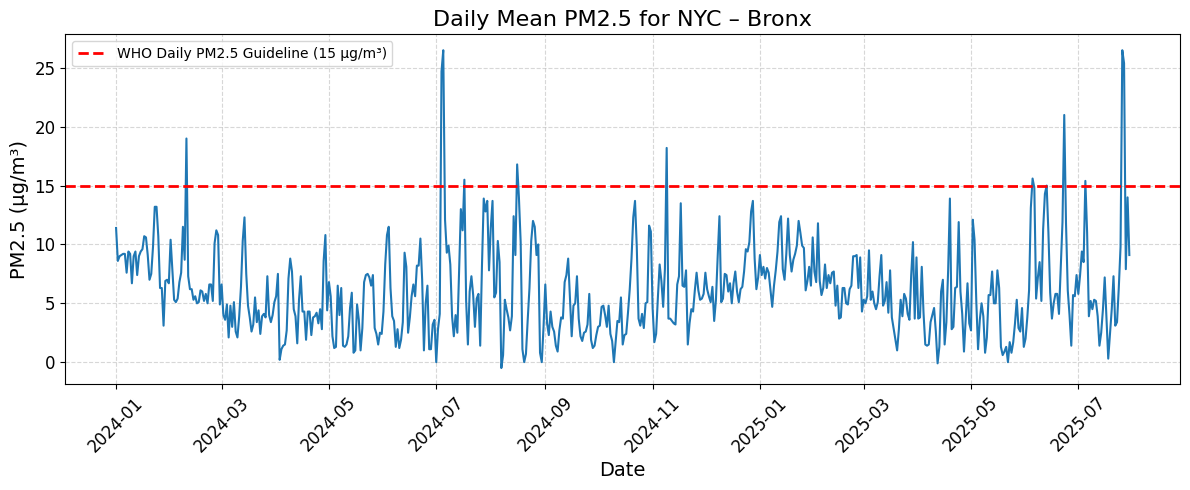

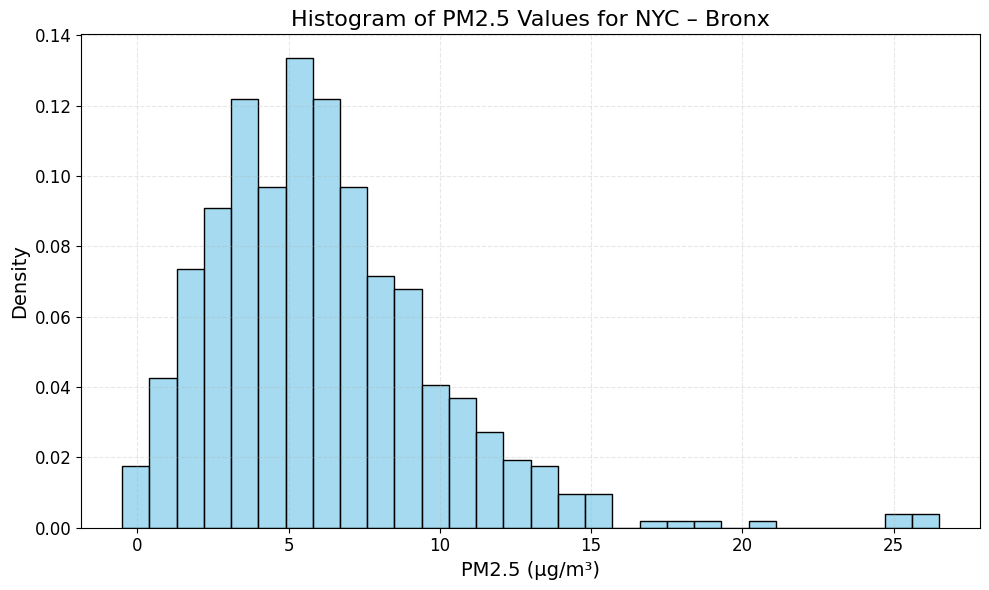

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
sensor_dir = "files/EPA_PM/"
nyc_filename = "nyc_PM25_2024_2025.csv"

nyc_file = os.path.join(sensor_dir, nyc_filename)

nyc = pd.read_csv(nyc_file, low_memory=False)

# Convert date to datetime
nyc['date'] = pd.to_datetime(nyc['date'])

# Aggregate: daily mean across all sites
nyc_daily = nyc.groupby('date')['pm25'].mean().reset_index()

# ---------- Plot 1: Time series for NYC – Bronx ----------
plt.figure(figsize=(12, 5))
sns.lineplot(data=nyc_daily, x='date', y='pm25')
plt.axhline(15, color='red', linestyle='--', linewidth=2, label="WHO Daily PM2.5 Guideline (15 µg/m³)")
plt.title("Daily Mean PM2.5 for NYC – Bronx", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("PM2.5 (µg/m³)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot 2: Histogram for NYC – Bronx ----------
plt.figure(figsize=(10,6))
sns.histplot(data=nyc_daily, x="pm25", bins=30, color='skyblue', stat="density")
plt.title("Histogram of PM2.5 Values for NYC – Bronx", fontsize=16)
plt.xlabel("PM2.5 (µg/m³)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Plot Daily PM2.5 for All Cities

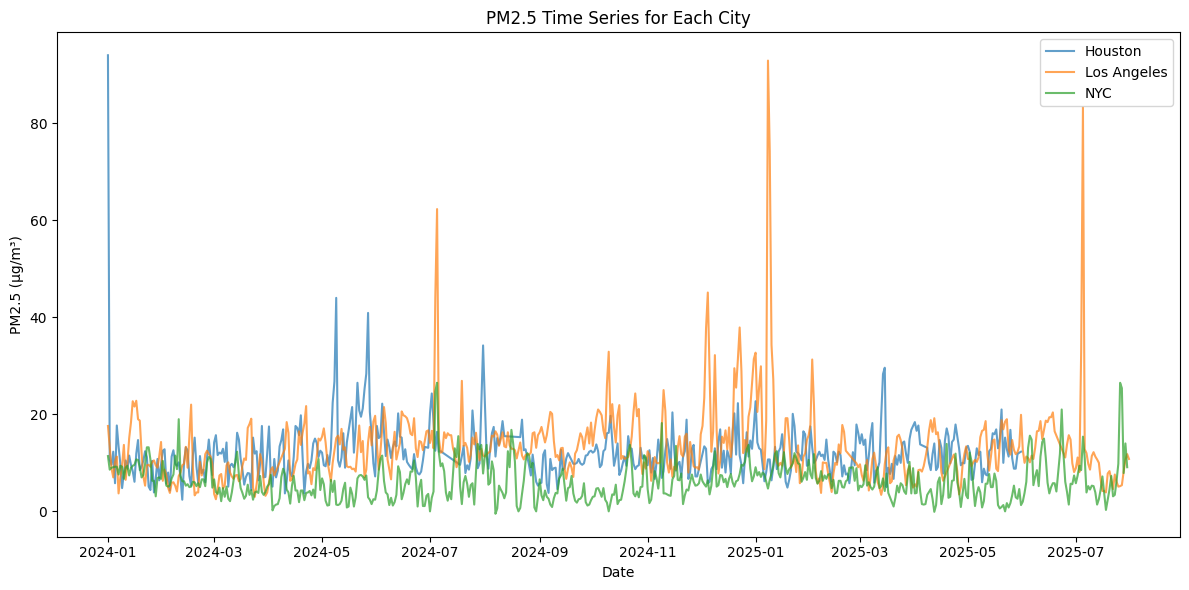

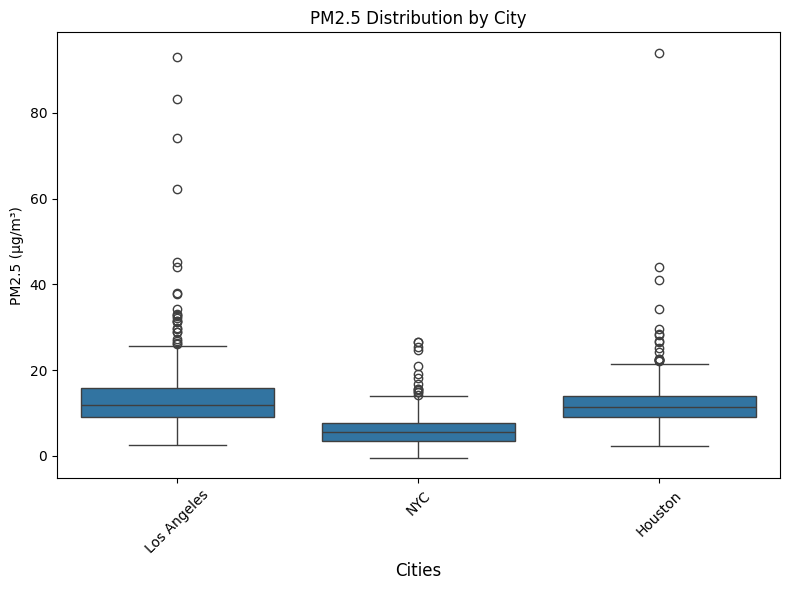

In [24]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sensor_dir = "files/EPA_PM/"

# ---------- COMBINE ALL FILES ----------
all_files = glob.glob(os.path.join(sensor_dir, "*.csv"))
df_list = [pd.read_csv(f, low_memory=False) for f in all_files]
df = pd.concat(df_list, ignore_index=True)

# Convert date column
df["date"] = pd.to_datetime(df["date"])


# ---------- PLOTS ----------
# 1. PM2.5 time series (each site)
plt.figure(figsize=(12,6))
for sid, g in df.groupby("city"):
    plt.plot(g["date"], g["pm25"], label=f"{sid}", alpha=0.7)
plt.legend()
plt.title("PM2.5 Time Series for Each City")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.show()


# 2. Boxplot by site
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="city", y="pm25")
plt.title("PM2.5 Distribution by City")
plt.xlabel("Cities", fontsize=12)
plt.ylabel("PM2.5 (µg/m³)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Key Takeaways:**
- City differences: We see some clear differences. New York City usually has lowest PM2.5 compared to other cities.
- Some anomalies refer could be wildfires or local combustion events.

## 4. Training Linear Fitted Line by Combining AOD and PM2.5 Data

### Los Angeles

In [25]:
import pandas as pd
import os

# ===== Load ground-level PM2.5 =====
sensor_dir = "files/EPA_PM/"
city_filename = "losangeles_PM25_2024_2025.csv"
city_file = os.path.join(sensor_dir, city_filename)
df_s = pd.read_csv(city_file, low_memory=False)

# ===== Load AOD =====
aod_dir = "files/EE_AOD/"
aod_filename = "Los Angeles.csv"
aod_file = os.path.join(aod_dir, aod_filename)
df_a = pd.read_csv(aod_file, low_memory=False)

# ---------- Standardize date formats ----------
# Ensure the date columns are in datetime format
df_s['date'] = pd.to_datetime(df_s['date'])
df_a['date'] = pd.to_datetime(df_a['date'])

# ---------- Merge AOD and PM2.5 ----------
# Merge on 'date'
df_merged = df_a.merge(
    df_s[['date', 'pm25']],  # only include pm25 from sensor data
    on='date',
    how='left'  # keep all AOD rows, add PM2.5 where available
)

# Drop rows with NA in any column
df_la = df_merged.dropna()
df_la['city']='Los Angeles'
print(df_la.head())
#print(df_final.info())

        date  aod_550  pm25         city
0 2024-01-01    0.072  17.6  Los Angeles
1 2024-01-02    0.088  13.2  Los Angeles
2 2024-01-03    0.084   8.9  Los Angeles
3 2024-01-04    0.052   7.0  Los Angeles
4 2024-01-05    0.042  10.2  Los Angeles


/tmp/ipython-input-598714119.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_la['city']='Los Angeles'


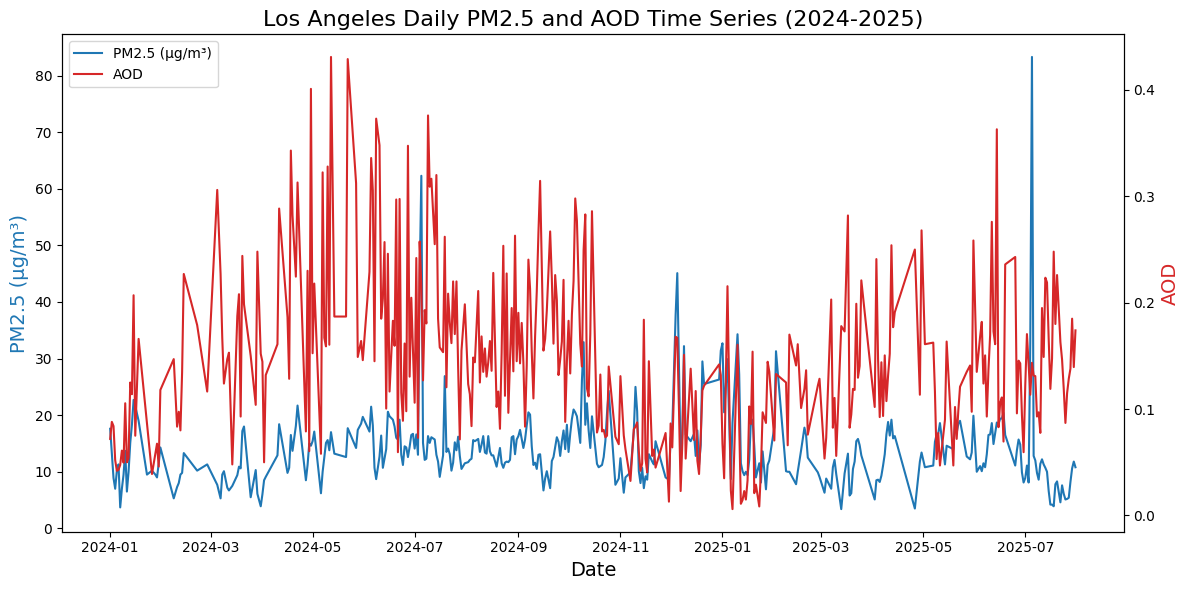

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot PM2.5 on left y-axis
ax1 = plt.gca()
line1, = ax1.plot(df_la['date'], df_la['pm25'], color='tab:blue', label='PM2.5 (µg/m³)')

# Create secondary y-axis for AOD
ax2 = ax1.twinx()
line2, = ax2.plot(df_la['date'], df_la['aod_550'], color='tab:red', label='AOD')

# Titles and labels
plt.title("Los Angeles Daily PM2.5 and AOD Time Series (2024-2025)", fontsize=16)
ax1.set_xlabel("Date", fontsize=14)
ax1.set_ylabel("PM2.5 (µg/m³)", color='tab:blue', fontsize=14)
ax2.set_ylabel("AOD", color='tab:red', fontsize=14)

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Legends
plt.legend(handles=[line1, line2], loc='upper left')

plt.tight_layout()
plt.show()

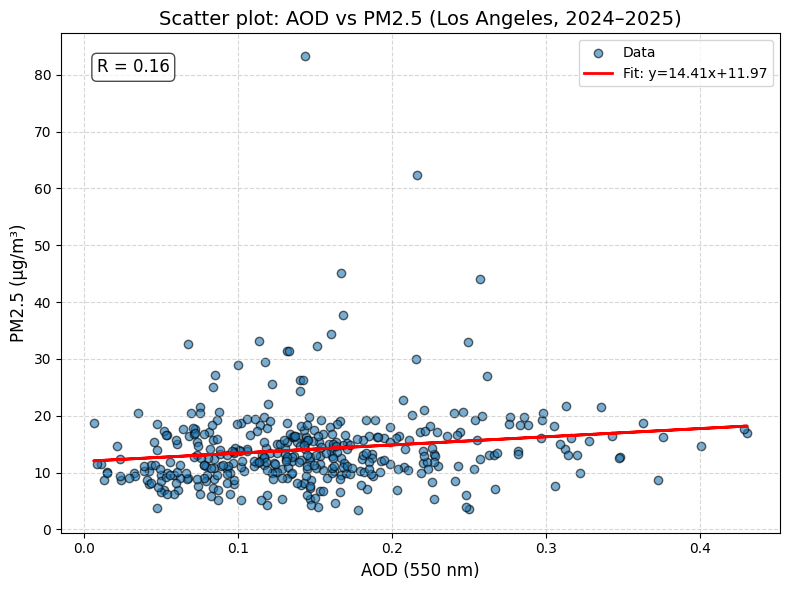

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Extract variables
x = df_la['aod_550'].values
y = df_la['pm25'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

# Plot scatter
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.6, edgecolor='k', label="Data")

# Plot fitted line
plt.plot(x, line, color='red', linewidth=2, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")

# Labels and title
plt.title("Scatter plot: AOD vs PM2.5 (Los Angeles, 2024–2025)", fontsize=14)
plt.xlabel("AOD (550 nm)", fontsize=12)
plt.ylabel("PM2.5 (µg/m³)", fontsize=12)

# Annotate R
plt.text(0.05, 0.95,
         f"R = {r_value:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment="top",
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# Legend + grid
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### NYC

In [28]:
import pandas as pd
import os

# ===== Load ground-level PM2.5 =====
sensor_dir = "files/EPA_PM/"
city_filename = "nyc_PM25_2024_2025.csv"
city_file = os.path.join(sensor_dir, city_filename)
df_s = pd.read_csv(city_file, low_memory=False)

# ===== Load AOD =====
aod_dir = "files/EE_AOD/"
aod_filename = "NYC.csv"
aod_file = os.path.join(aod_dir, aod_filename)
df_a = pd.read_csv(aod_file, low_memory=False)

# ---------- Standardize date formats ----------
# Ensure the date columns are in datetime format
df_s['date'] = pd.to_datetime(df_s['date'])
df_a['date'] = pd.to_datetime(df_a['date'])

# ---------- Merge AOD and PM2.5 ----------
# Merge on 'date'
df_merged = df_a.merge(
    df_s[['date', 'pm25']],  # only include pm25 from sensor data
    on='date',
    how='left'  # keep all AOD rows, add PM2.5 where available
)

# Drop rows with NA in any column
df_nyc = df_merged.dropna()
df_nyc['city']='NYC'
print(df_la.head())
#print(df_final.info())

        date  aod_550  pm25         city
0 2024-01-01    0.072  17.6  Los Angeles
1 2024-01-02    0.088  13.2  Los Angeles
2 2024-01-03    0.084   8.9  Los Angeles
3 2024-01-04    0.052   7.0  Los Angeles
4 2024-01-05    0.042  10.2  Los Angeles


/tmp/ipython-input-2931792125.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nyc['city']='NYC'


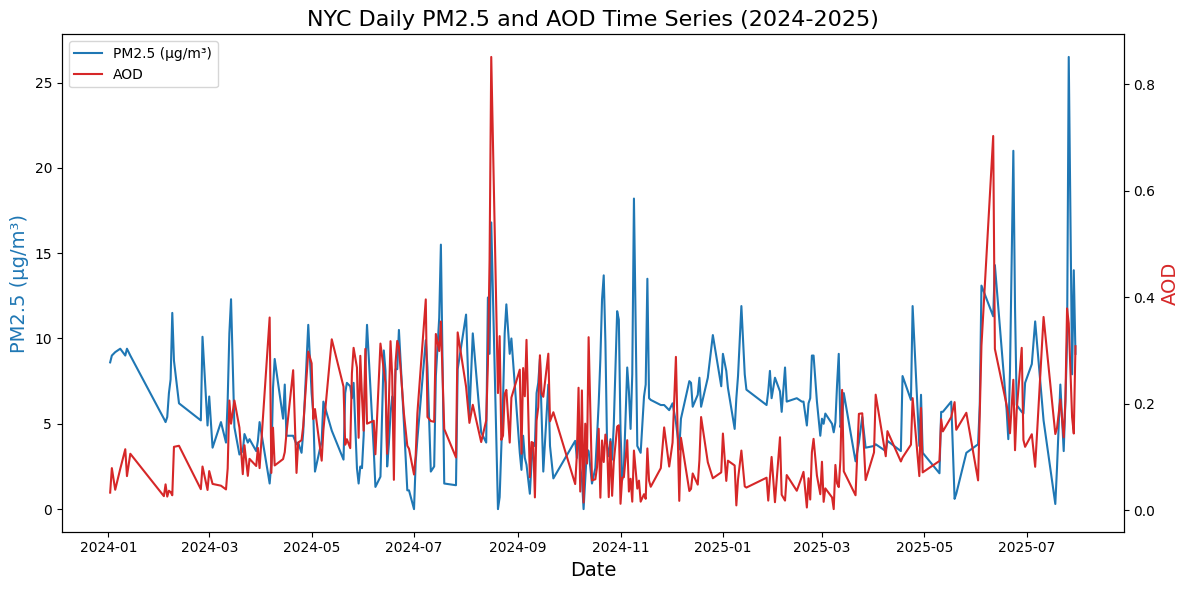

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot PM2.5 on left y-axis
ax1 = plt.gca()
line1, = ax1.plot(df_nyc['date'], df_nyc['pm25'], color='tab:blue', label='PM2.5 (µg/m³)')

# Create secondary y-axis for AOD
ax2 = ax1.twinx()
line2, = ax2.plot(df_nyc['date'], df_nyc['aod_550'], color='tab:red', label='AOD')

# Titles and labels
plt.title("NYC Daily PM2.5 and AOD Time Series (2024-2025)", fontsize=16)
ax1.set_xlabel("Date", fontsize=14)
ax1.set_ylabel("PM2.5 (µg/m³)", color='tab:blue', fontsize=14)
ax2.set_ylabel("AOD", color='tab:red', fontsize=14)

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Legends
plt.legend(handles=[line1, line2], loc='upper left')

plt.tight_layout()
plt.show()

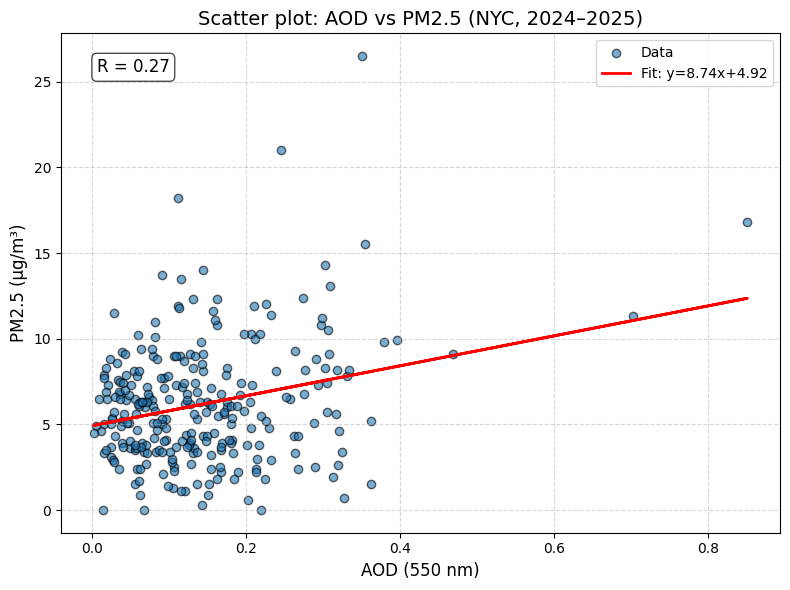

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Extract variables
x = df_nyc['aod_550'].values
y = df_nyc['pm25'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

# Plot scatter
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.6, edgecolor='k', label="Data")

# Plot fitted line
plt.plot(x, line, color='red', linewidth=2, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")

# Labels and title
plt.title("Scatter plot: AOD vs PM2.5 (NYC, 2024–2025)", fontsize=14)
plt.xlabel("AOD (550 nm)", fontsize=12)
plt.ylabel("PM2.5 (µg/m³)", fontsize=12)

# Annotate R
plt.text(0.05, 0.95,
         f"R = {r_value:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment="top",
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# Legend + grid
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Houston

In [31]:
import pandas as pd
import os

# ===== Load ground-level PM2.5 =====
sensor_dir = "files/EPA_PM/"
city_filename = "houston_PM25_2024_2025.csv"
city_file = os.path.join(sensor_dir, city_filename)
df_s = pd.read_csv(city_file, low_memory=False)

# ===== Load AOD =====
aod_dir = "files/EE_AOD/"
aod_filename = "Houston.csv"
aod_file = os.path.join(aod_dir, aod_filename)
df_a = pd.read_csv(aod_file, low_memory=False)

# ---------- Standardize date formats ----------
# Ensure the date columns are in datetime format
df_s['date'] = pd.to_datetime(df_s['date'])
df_a['date'] = pd.to_datetime(df_a['date'])

# ---------- Merge AOD and PM2.5 ----------
# Merge on 'date'
df_merged = df_a.merge(
    df_s[['date', 'pm25']],  # only include pm25 from sensor data
    on='date',
    how='left'  # keep all AOD rows, add PM2.5 where available
)

# Drop rows with NA in any column
df_h = df_merged.dropna()
df_h['city']='Houston'
print(df_la.head())
#print(df_final.info())

        date  aod_550  pm25         city
0 2024-01-01    0.072  17.6  Los Angeles
1 2024-01-02    0.088  13.2  Los Angeles
2 2024-01-03    0.084   8.9  Los Angeles
3 2024-01-04    0.052   7.0  Los Angeles
4 2024-01-05    0.042  10.2  Los Angeles


/tmp/ipython-input-2626098205.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_h['city']='Houston'


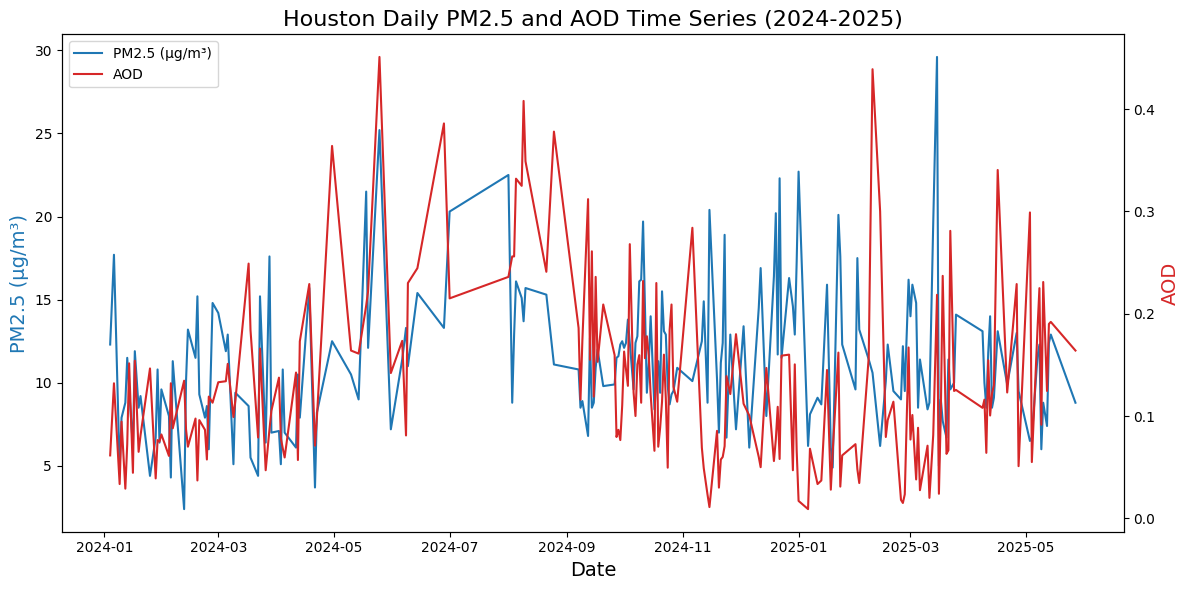

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot PM2.5 on left y-axis
ax1 = plt.gca()
line1, = ax1.plot(df_h['date'], df_h['pm25'], color='tab:blue', label='PM2.5 (µg/m³)')

# Create secondary y-axis for AOD
ax2 = ax1.twinx()
line2, = ax2.plot(df_h['date'], df_h['aod_550'], color='tab:red', label='AOD')

# Titles and labels
plt.title("Houston Daily PM2.5 and AOD Time Series (2024-2025)", fontsize=16)
ax1.set_xlabel("Date", fontsize=14)
ax1.set_ylabel("PM2.5 (µg/m³)", color='tab:blue', fontsize=14)
ax2.set_ylabel("AOD", color='tab:red', fontsize=14)

# Rotate x-axis ticks
plt.xticks(rotation=45)

# Legends
plt.legend(handles=[line1, line2], loc='upper left')

plt.tight_layout()
plt.show()

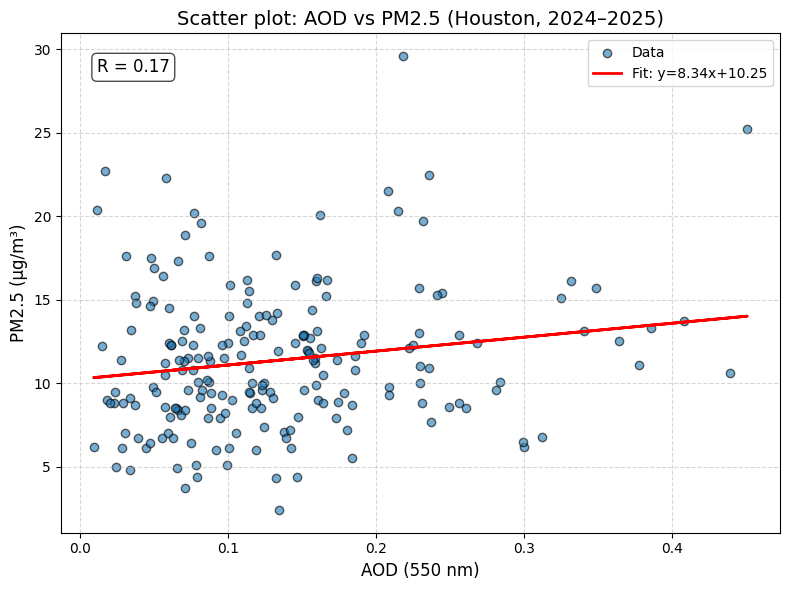

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Extract variables
x = df_h['aod_550'].values
y = df_h['pm25'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

# Plot scatter
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.6, edgecolor='k', label="Data")

# Plot fitted line
plt.plot(x, line, color='red', linewidth=2, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")

# Labels and title
plt.title("Scatter plot: AOD vs PM2.5 (Houston, 2024–2025)", fontsize=14)
plt.xlabel("AOD (550 nm)", fontsize=12)
plt.ylabel("PM2.5 (µg/m³)", fontsize=12)

# Annotate R
plt.text(0.05, 0.95,
         f"R = {r_value:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment="top",
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# Legend + grid
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## Model presenting all cities

#### Combine data from all three cities

In [56]:
df_all = pd.concat([df_la,df_nyc,df_h],ignore_index=True)

#### Build regression model

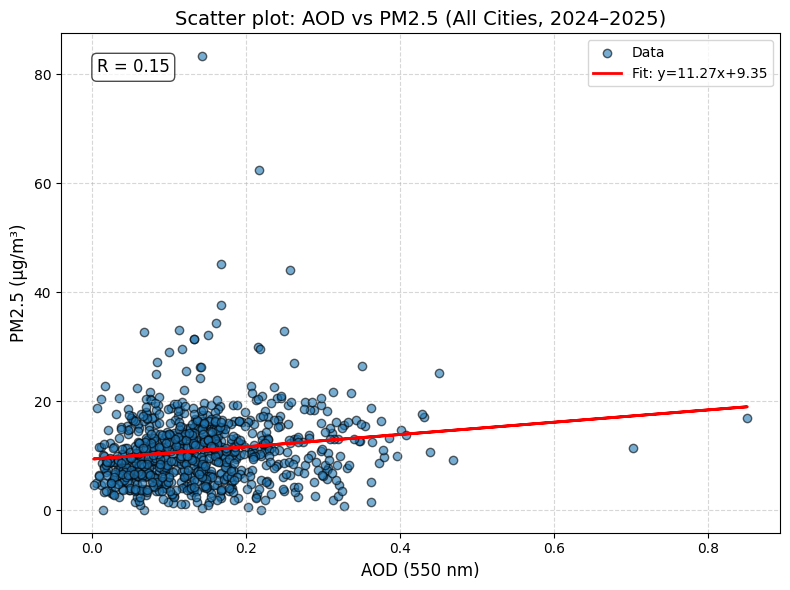

In [57]:
# Extract variables
x = df_all['aod_550'].values
y = df_all['pm25'].values

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

# Plot scatter
plt.figure(figsize=(8,6))
plt.scatter(x, y, alpha=0.6, edgecolor='k', label="Data")

# Plot fitted line
plt.plot(x, line, color='red', linewidth=2, label=f"Fit: y={slope:.2f}x+{intercept:.2f}")

# Labels and title
plt.title("Scatter plot: AOD vs PM2.5 (All Cities, 2024–2025)", fontsize=14)
plt.xlabel("AOD (550 nm)", fontsize=12)
plt.ylabel("PM2.5 (µg/m³)", fontsize=12)

# Annotate R
plt.text(0.05, 0.95,
         f"R = {r_value:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12,
         verticalalignment="top",
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# Legend + grid
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

## AOD to PM2.5 Equation

In [58]:
# Intercept and coefficient
x = df_all['aod_550'].values
y = df_all['pm25'].values

slope, intercept, r_value, p_value, std_err = linregress(x, y)
line = slope * x + intercept

#intercept = 9.345 #intercept_f
#coef = 11.273 #slope_f

print(f"Linear regression equation is: PM2.5 = {intercept:.3f} + {slope:.3f} * AOD")

Linear regression equation is: PM2.5 = 9.345 + 11.273 * AOD


In [59]:
slope_f = slope
intercept_f = intercept

## 7. Produce Spatial Map of PM2.5

We will use MERRA-2 reanalysis data to visualize AOD here. It assimilates products from various sources to produce a better coverage maps.\
**Date:** August 1, 2025

In [60]:
import xarray as xr

ds = xr.open_dataset("files/NASA_AOD/MERRA2_400.tavg1_2d_aer_Nx.20250801.nc4")

ds

<xarray.Dataset> Size: 998MB
Dimensions:    (time: 24, lat: 361, lon: 576)
Coordinates:
  * time       (time) datetime64[ns] 192B 2025-08-01T00:30:00 ... 2025-08-01T...
  * lat        (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
Data variables: (12/50)
    BCANGSTR   (time, lat, lon) float32 20MB ...
    BCCMASS    (time, lat, lon) float32 20MB ...
    BCEXTTAU   (time, lat, lon) float32 20MB ...
    BCFLUXU    (time, lat, lon) float32 20MB ...
    BCFLUXV    (time, lat, lon) float32 20MB ...
    BCSCATAU   (time, lat, lon) float32 20MB ...
    ...         ...
    SUFLUXU    (time, lat, lon) float32 20MB ...
    SUFLUXV    (time, lat, lon) float32 20MB ...
    SUSCATAU   (time, lat, lon) float32 20MB ...
    TOTANGSTR  (time, lat, lon) float32 20MB ...
    TOTEXTTAU  (time, lat, lon) float32 20MB ...
    TOTSCATAU  (time, lat, lon) float32 20MB ...
Attributes: (12/30)
    History:                           Original file generated: Mon Aug 11 20...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_aer_Nx.20250801.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/KLICLTZ8EM9D
    RangeBeginningDate:                2025-08-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2025-08-01
    RangeEndingTime:                   23:59:59.000000

In [61]:
print(ds.data_vars)

Data variables:
    BCANGSTR   (time, lat, lon) float32 20MB ...
    BCCMASS    (time, lat, lon) float32 20MB ...
    BCEXTTAU   (time, lat, lon) float32 20MB ...
    BCFLUXU    (time, lat, lon) float32 20MB ...
    BCFLUXV    (time, lat, lon) float32 20MB ...
    BCSCATAU   (time, lat, lon) float32 20MB ...
    BCSMASS    (time, lat, lon) float32 20MB ...
    DMSCMASS   (time, lat, lon) float32 20MB ...
    DMSSMASS   (time, lat, lon) float32 20MB ...
    DUANGSTR   (time, lat, lon) float32 20MB ...
    DUCMASS    (time, lat, lon) float32 20MB ...
    DUCMASS25  (time, lat, lon) float32 20MB ...
    DUEXTT25   (time, lat, lon) float32 20MB ...
    DUEXTTAU   (time, lat, lon) float32 20MB ...
    DUFLUXU    (time, lat, lon) float32 20MB ...
    DUFLUXV    (time, lat, lon) float32 20MB ...
    DUSCAT25   (time, lat, lon) float32 20MB ...
    DUSCATAU   (time, lat, lon) float32 20MB ...
    DUSMASS    (time, lat, lon) float32 20MB ...
    DUSMASS25  (time, lat, lon) float32 20MB ...
    

In [62]:
aod = ds["TOTEXTTAU"]
aod

<xarray.DataArray 'TOTEXTTAU' (time: 24, lat: 361, lon: 576)> Size: 20MB
[4990464 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 192B 2025-08-01T00:30:00 ... 2025-08-01T23...
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    long_name:       Total Aerosol Extinction AOT [550 nm]
    units:           1
    fmissing_value:  1000000000000000.0
    standard_name:   Total Aerosol Extinction AOT [550 nm]
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

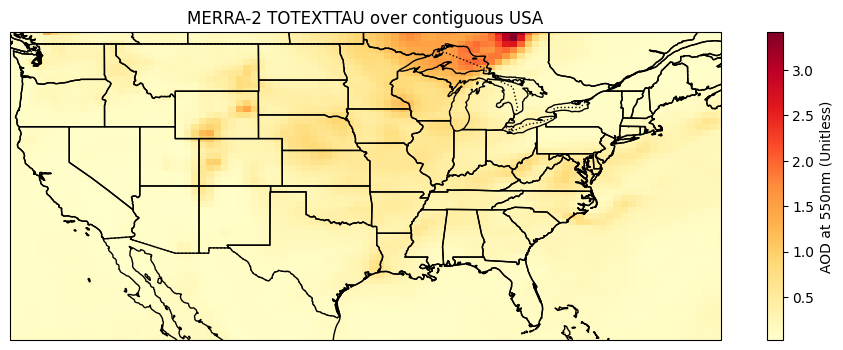

In [63]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load dataset
ds = xr.open_dataset("files/NASA_AOD/MERRA2_400.tavg1_2d_aer_Nx.20250801.nc4")

aod = ds["TOTEXTTAU"].isel(time=12)

# Subset for USA
aod_usa = aod.sel(lat=slice(24, 50), lon=slice(-125, -65))

# Create figure with PlateCarree projection
fig, ax = plt.subplots(figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot AOD
pcm = aod_usa.plot(ax=ax, cmap='YlOrRd', add_colorbar=True,
                   cbar_kwargs={'label':'AOD at 550nm (Unitless)'}, transform=ccrs.PlateCarree())

# Add states and coastlines
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set extent to USA
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())

# Title
ax.set_title("MERRA-2 TOTEXTTAU over contiguous USA", fontsize=12)

plt.show()

#### Calculate PM2.5 using AOD

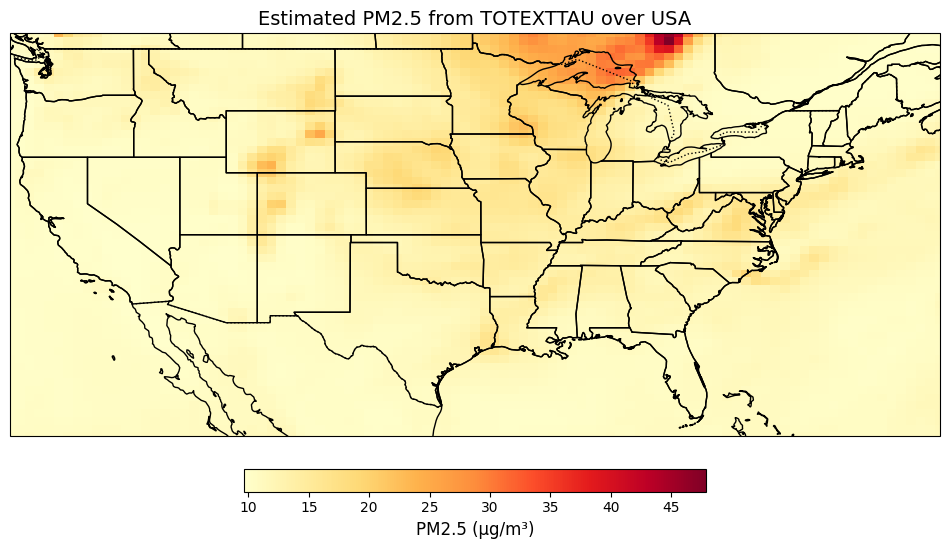

In [64]:
# Compute PM2.5
pm25_usa = aod_usa * slope_f + intercept_f

# Plot
fig, ax = plt.subplots(figsize=(12,6), subplot_kw={'projection': ccrs.PlateCarree()})

pcm = pm25_usa.plot(ax=ax, cmap='YlOrRd', add_colorbar=False, transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set extent
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())

# Title
ax.set_title("Estimated PM2.5 from TOTEXTTAU over USA", fontsize=14)

# Horizontal colorbar
cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.show()

### PM2.5 in California

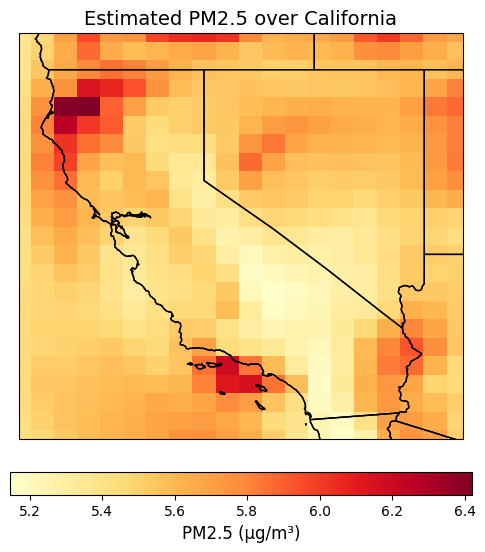

In [88]:
# Subset for California
aod_r = ds["TOTEXTTAU"].isel(time=12)

pm25_ca = aod_r.sel(lat=slice(32, 43), lon=slice(-125, -113)) * 8.74 + 4.92

# Plot
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': ccrs.PlateCarree()})

pcm = pm25_ca.plot(ax=ax, cmap='YlOrRd', add_colorbar=False, transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set extent to California
ax.set_extent([-125, -113, 32, 43], crs=ccrs.PlateCarree())

# Title
ax.set_title("Estimated PM2.5 over California", fontsize=14)

# Horizontal colorbar
cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.show()

### Multiple time snapshots to visualize LA

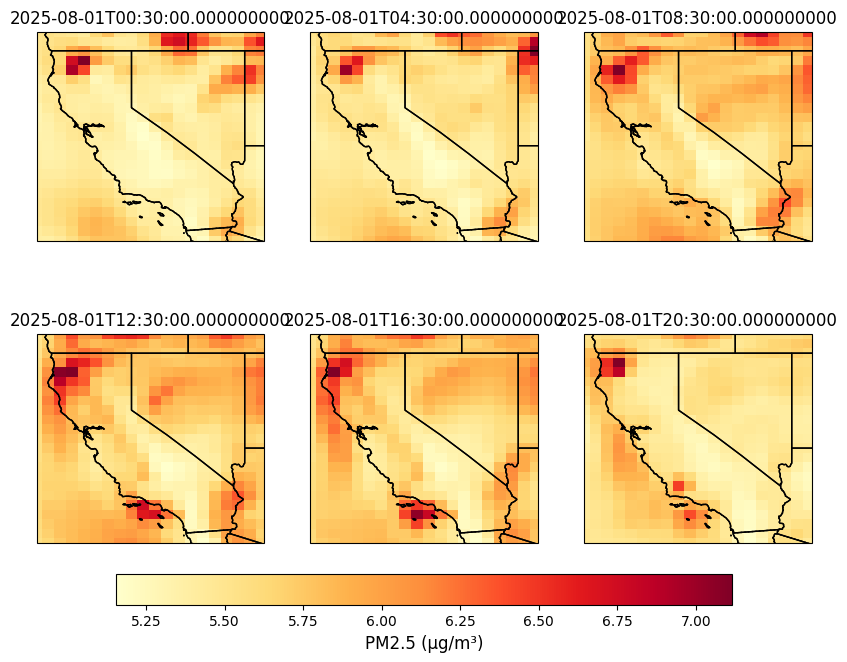

In [89]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load dataset
ds = xr.open_dataset("files/NASA_AOD/MERRA2_400.tavg1_2d_aer_Nx.20250801.nc4")

# Choose time indices for 6 plots, 4 hours apart (assuming hourly data)
time_indices = [0, 4, 8, 12, 16, 20]  # adjust if your dataset time resolution differs

# Create figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(10,8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, t in enumerate(time_indices):
    aod = ds["TOTEXTTAU"].isel(time=t)
    pm25_ca = aod.sel(lat=slice(32, 43), lon=slice(-125, -113)) * 8.74 + 4.92

    pcm = pm25_ca.plot(
        ax=axes[i], cmap='YlOrRd', add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

    axes[i].add_feature(cfeature.STATES, edgecolor='black')
    axes[i].add_feature(cfeature.COASTLINE)
    axes[i].add_feature(cfeature.BORDERS, linestyle=':')
    axes[i].set_extent([-125, -113, 32, 43], crs=ccrs.PlateCarree())
    # Include time in title
    axes[i].set_title(str(pm25_ca.time.values), fontsize=12)

# Add a single horizontal colorbar at the bottom
cbar = fig.colorbar(pcm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

#plt.tight_layout()
plt.show()

**Key Takeaways:**
- Hotspots: The spatial plot indicates potential PM2.5 hotspots across the map.
- It also shows evolution of special events, such as wildfires in Northern California.

Activity:
1. Download MERRA-2 files from NASA (January 8–10)
2. Plot PM2.5 in California for the three dates
3. Multiple time snapshots to visualize LA fires (4 hour interval plots for the three days)

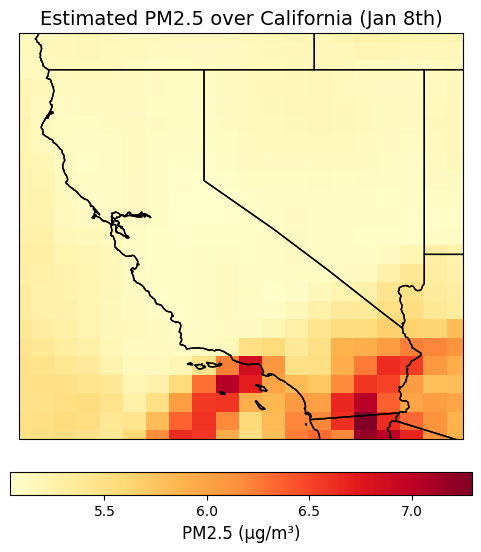

In [90]:
from pyproj import transform
# Fill you code here
ds1 = xr.open_dataset("files/NASA_AOD/MERRA2_400.tavg1_2d_aer_Nx.20250108.nc4")
aod_r = ds1["TOTEXTTAU"].isel(time=12)

pm25_ca = aod_r.sel(lat=slice(32,43), lon=slice(-125,-113)) * 8.74 + 4.92

fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': ccrs.PlateCarree()})
pcm = pm25_ca.plot(ax=ax, cmap='YlOrRd', add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.set_extent([-125, -113,32,43], crs=ccrs.PlateCarree())

ax.set_title("Estimated PM2.5 over California (Jan 8th)", fontsize=14)

cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.show()


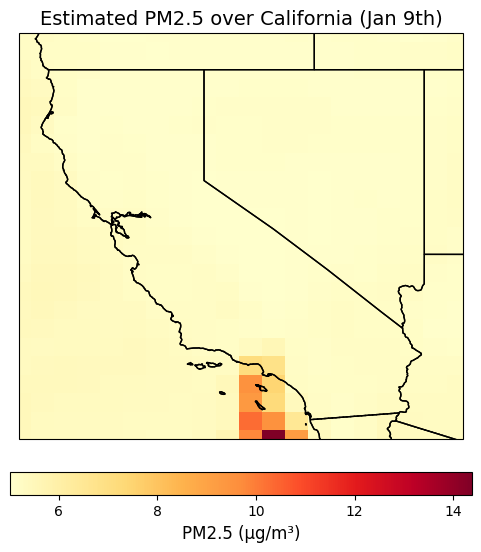

In [91]:
ds2 = xr.open_dataset("files/NASA_AOD/MERRA2_400.tavg1_2d_aer_Nx.20250109.nc4")
aod_r = ds2["TOTEXTTAU"].isel(time=12)

pm25_ca = aod_r.sel(lat=slice(32,43), lon=slice(-125,-113)) * 8.74 + 4.92

fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': ccrs.PlateCarree()})
pcm = pm25_ca.plot(ax=ax, cmap='YlOrRd', add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.set_extent([-125, -113,32,43], crs=ccrs.PlateCarree())

ax.set_title("Estimated PM2.5 over California (Jan 9th)", fontsize=14)

cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.show()

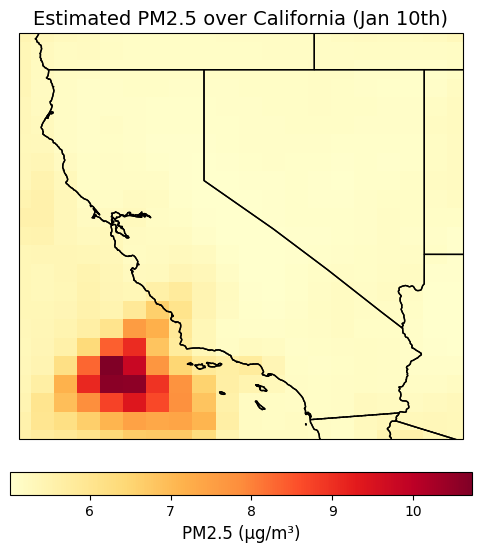

In [92]:
ds3 = xr.open_dataset("files/NASA_AOD/MERRA2_400.tavg1_2d_aer_Nx.20250110.nc4")
aod_r = ds3["TOTEXTTAU"].isel(time=12)

pm25_ca = aod_r.sel(lat=slice(32,43), lon=slice(-125,-113)) * 8.74 + 4.92

fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': ccrs.PlateCarree()})
pcm = pm25_ca.plot(ax=ax, cmap='YlOrRd', add_colorbar=False, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.set_extent([-125, -113,32,43], crs=ccrs.PlateCarree())

ax.set_title("Estimated PM2.5 over California (Jan 10th)", fontsize=14)

cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.show()

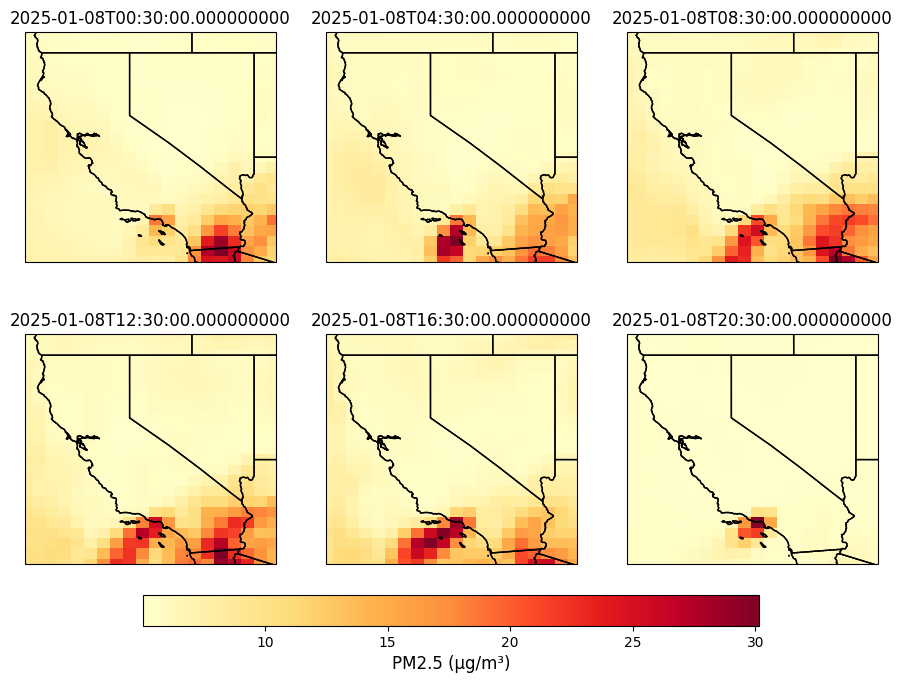

In [95]:
# Load dataset
ds1 = xr.open_dataset("files/NASA_AOD/MERRA2_400.tavg1_2d_aer_Nx.20250108.nc4")

# Choose time indices for 6 plots, 4 hours apart (assuming hourly data)
time_indices = [0, 4, 8, 12, 16, 20]  # adjust if your dataset time resolution differs

# Create figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(11, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, t in enumerate(time_indices):
    aod = ds1["TOTEXTTAU"].isel(time=t)
    pm25_ca = aod.sel(lat=slice(32, 43), lon=slice(-125, -113)) * 8.74 + 4.92

    pcm = pm25_ca.plot(
        ax=axes[i], cmap='YlOrRd', add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

    axes[i].add_feature(cfeature.STATES, edgecolor='black')
    axes[i].add_feature(cfeature.COASTLINE)
    axes[i].add_feature(cfeature.BORDERS, linestyle=':')
    axes[i].set_extent([-125, -113, 32, 43], crs=ccrs.PlateCarree())
    # Include time in title
    axes[i].set_title(str(pm25_ca.time.values), fontsize=12)

# Add a single horizontal colorbar at the bottom
cbar = fig.colorbar(pcm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

#plt.tight_layout()
plt.show()

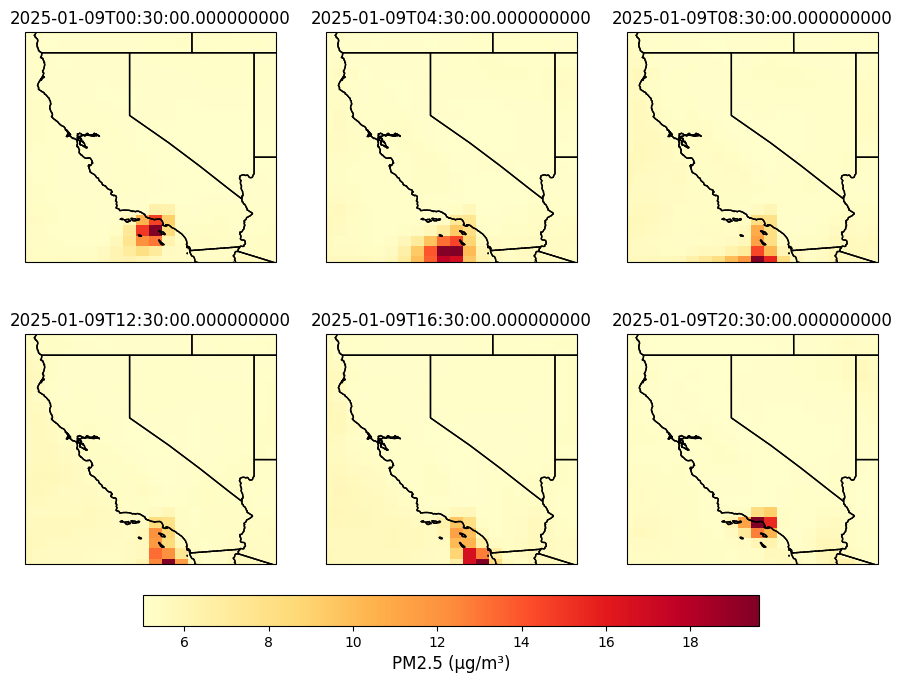

In [93]:
# Load dataset
ds2 = xr.open_dataset("files/NASA_AOD/MERRA2_400.tavg1_2d_aer_Nx.20250109.nc4")

# Choose time indices for 6 plots, 4 hours apart (assuming hourly data)
time_indices = [0, 4, 8, 12, 16, 20]  # adjust if your dataset time resolution differs

# Create figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(11, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, t in enumerate(time_indices):
    aod = ds2["TOTEXTTAU"].isel(time=t)
    pm25_ca = aod.sel(lat=slice(32, 43), lon=slice(-125, -113)) * 8.74 + 4.92

    pcm = pm25_ca.plot(
        ax=axes[i], cmap='YlOrRd', add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

    axes[i].add_feature(cfeature.STATES, edgecolor='black')
    axes[i].add_feature(cfeature.COASTLINE)
    axes[i].add_feature(cfeature.BORDERS, linestyle=':')
    axes[i].set_extent([-125, -113, 32, 43], crs=ccrs.PlateCarree())
    # Include time in title
    axes[i].set_title(str(pm25_ca.time.values), fontsize=12)

# Add a single horizontal colorbar at the bottom
cbar = fig.colorbar(pcm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

#plt.tight_layout()
plt.show()

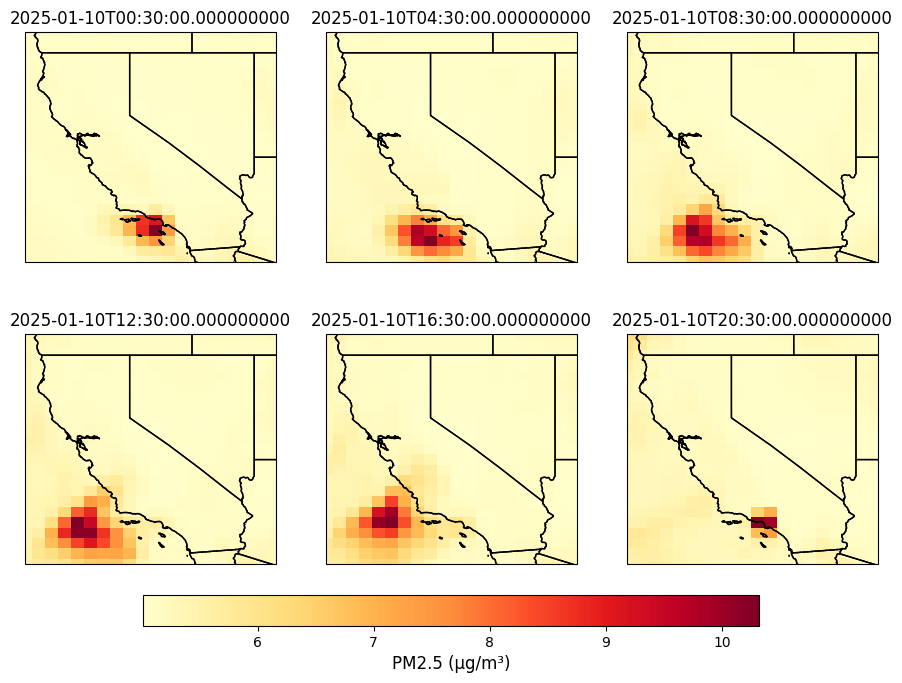

In [94]:
# Load dataset
ds3 = xr.open_dataset("files/NASA_AOD/MERRA2_400.tavg1_2d_aer_Nx.20250110.nc4")

# Choose time indices for 6 plots, 4 hours apart (assuming hourly data)
time_indices = [0, 4, 8, 12, 16, 20]  # adjust if your dataset time resolution differs

# Create figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(11, 8), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, t in enumerate(time_indices):
    aod = ds3["TOTEXTTAU"].isel(time=t)
    pm25_ca = aod.sel(lat=slice(32, 43), lon=slice(-125, -113)) * 8.74 + 4.92

    pcm = pm25_ca.plot(
        ax=axes[i], cmap='YlOrRd', add_colorbar=False,
        transform=ccrs.PlateCarree()
    )

    axes[i].add_feature(cfeature.STATES, edgecolor='black')
    axes[i].add_feature(cfeature.COASTLINE)
    axes[i].add_feature(cfeature.BORDERS, linestyle=':')
    axes[i].set_extent([-125, -113, 32, 43], crs=ccrs.PlateCarree())
    # Include time in title
    axes[i].set_title(str(pm25_ca.time.values), fontsize=12)

# Add a single horizontal colorbar at the bottom
cbar = fig.colorbar(pcm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.05)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

#plt.tight_layout()
plt.show()

## Next Steps:
- Try using real MODIS AOD datasets (download from NASA Earthdata)
- Use EPA ground monitor data for PM2.5
- Explore advanced ML models (Random Forest, XGBoost, Neural Networks)